In [1]:
# Bad subjects
# Bad IDs: 605515760919, 601983541597

# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

466
156
{'meta': {'AgeInMonths': 146, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '30', 'nback': '31', 'emoid': '31', 'ID': 600262185931}


In [2]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [3]:
# Normalize data

import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [4]:
# Create labels (ages)

y_train = np.vstack([subj['meta']['AgeInMonths'] for subj in train])
y_test = np.vstack([subj['meta']['AgeInMonths'] for subj in test])

print('Complete')

Complete


In [5]:
# Torch

import torch
import torch.nn as nn
import torch.nn.functional as F

cuda = torch.device('cuda')

train_rest_ts_torch = [torch.from_numpy(subj).float().cuda() for subj in train_rest_ts]
test_rest_ts_torch = [torch.from_numpy(subj).float().cuda() for subj in test_rest_ts]

# print(train_rest_ts_torch[0].device)
# print(train_rest_ts_torch[0].shape)
print('Complete')

Complete


In [20]:
# Functional connectivity

from math import floor as f

import matplotlib.pyplot as plt
import scipy.linalg

# Calculate the Pearson correlation coefficient
# Assumes normalized to mean=0 and std=1
def pearsonr(ts):
    nt = ts.shape[1]
    return ts@ts.T/nt

# Threshold at some 0 < pct < 1 of edges
def threshold(fc, pct, keepNeg=False):
    # Set main diagonal to zero
    N = fc.shape[0]
    fc -= np.eye(N)
    # Do not count edges on main diagonal
    # This means we will never get odd number of edges
    # If, for instance, we use 100% of edges
    nedge = N*N-N 
    nedgeThr = f(nedge*pct)
    if nedgeThr % 2 == 1:
        nedgeThr += 1
    vec = -np.abs(fc.reshape(-1)) if keepNeg else -fc.reshape(-1)
    indcs = np.argsort(vec)[0:nedgeThr]
    binfc = np.zeros(N*N)
    binfc[indcs] = 1
    return binfc.reshape(fc.shape)

# Find the degree matrix of a thresholded binary pearson matrix
def degree(A):
    d = np.sum(A,axis=0)
    d[np.where(d==0)] = 1e-5 # Avoid singularity
    return np.diag(d)

# Find the normalized Laplacian
def Laplacian(A):
    D = degree(A)
    invSqrtD = np.linalg.inv(scipy.linalg.sqrtm(D))
    return np.eye(A.shape[0])-invSqrtD@A@invSqrtD

# Return chebyshev polynomial of order K
def Chebyshev(L, k):
    if k < 0 or k > 10:
        raise ValueError('Bad value for order of Chebyshev polynomial')
    if k == 0:
        # Not sure if this should be 1 or I or if this recursion doesn't work for matrices
        return np.eye(L.shape[0]) 
    if k == 1:
        return L
    return 2*L@Chebyshev(L,k-1)-Chebyshev(L,k-2)

# The 4 orders of Chebyshev polynomials for spatial convolution
def AllChebyshev(L):
    global num
    print('{:d} '.format(num), end='')
    num += 1
    orders = [Chebyshev(L,0), Chebyshev(L,1), Chebyshev(L,2), Chebyshev(L,3)]
    orders = np.stack(orders)
    return torch.from_numpy(orders).float().cuda()

print('Complete')

Complete


In [35]:
# Make pearson tensors for FC_conv network

import torch
import torch.nn as nn
import torch.nn.functional as F

train_rest_p_torch = [torch.from_numpy(pearsonr(ts)).float().cuda() for ts in train_rest_ts]
test_rest_p_torch = [torch.from_numpy(pearsonr(ts)).float().cuda() for ts in test_rest_ts]

print('Complete')

Complete


In [21]:
# Make Chebyshev approximations to convolutional filters

num = 0
print('Completed... ', end='')
train_rest_cheb_torch = [AllChebyshev(Laplacian(threshold(pearsonr(ts), 0.2))) for ts in train_rest_ts]
print()

num = 0
print('Completed... ', end='')
test_rest_cheb_torch = [AllChebyshev(Laplacian(threshold(pearsonr(ts), 0.2))) for ts in test_rest_ts]
print()

print('Complete')

Completed... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 2

In [22]:
import torch

torch.cuda.empty_cache()

t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print('Total: {:f} Reserved: {:f} Allocated: {:f} Free: {:f}'.format(t,r,a,f))

Total: 4294967296.000000 Reserved: 1157627904.000000 Allocated: 1126431232.000000 Free: 31196672.000000


In [22]:
# Try ST-graph-conv first

# 8 filters with kernel size 6 in temporal dimension
# 8 spectral filters with Chebyshev polynomials of order 4
# temporal and spatial pooling with stride 2
# 3 output layers with 256, 256, and 1 hidden node; 2 dropout layers with rate=0.2
# LeakyReLU used in all layers with leak rate=0.33

nt = train_rest_ts_torch[0].shape[1]
nroi = train_rest_ts_torch[0].shape[0]

class ST_graph_conv(nn.Module):
    def __init__(self):
        super(ST_graph_conv, self).__init__()
        self.tc1 = nn.Conv2d(1,8,(1,6),(1,2)).cuda() # Output size A=f((nt-5)/2)
        self.tc2 = nn.Conv2d(8,8,(1,6),(1,2)).cuda() # Output size f((A-5)/2)
        self.sc1 = nn.Parameter(torch.zeros(4,8,8, requires_grad=True).cuda())
        self.sc2 = nn.Parameter(torch.zeros(4,8,8, requires_grad=True).cuda())
        self.sc1b = nn.Parameter(torch.zeros(8, requires_grad=True).cuda())
        self.sc2b = nn.Parameter(torch.zeros(8, requires_grad=True).cuda())
        self.sac1 = nn.Linear(nroi*2*8,10).cuda()
        self.sac2 = nn.Linear(nroi*2*8,10).cuda()
        self.fc1 = nn.Linear(20,256).cuda()
        self.fc2 = nn.Linear(256,256).cuda()
        self.fc3 = nn.Linear(256,1).cuda()
        self.lrelu = nn.LeakyReLU(0.33)
        self.dp = nn.Dropout(0.2)
        
    def forward(self, x):
        ts = x[0]
        tk = x[1] # nroi x nroi x 4
        nb = ts.shape[0]
        # First temporal convolution
        x = self.lrelu(self.tc1(ts))
        # First spatial convolution
        x = torch.einsum('abcd,aecf->abcf', x, tk)
        x = torch.einsum('abcf,dbg->agcf', x, self.sc1)
        x = x + self.sc1b.view(8,1,1)
        # First aggregate
        ymean = torch.mean(x,dim=3)
        ystd = torch.std(x,dim=3)
        y = torch.cat([ymean.view(nb,nroi*8), ystd.view(nb,nroi*8)],dim=1)
        y = self.lrelu(self.sac1(y))
        # Second temporal convolution
        x = self.lrelu(self.tc2(x))
        # Second spatial convolution
        x = torch.einsum('abcd,aecf->abcf', x, tk)
        x = torch.einsum('abcf,dbg->agcf', x, self.sc2)
        x = x + self.sc2b.view(8,1,1)
        # Second aggregate
        zmean = torch.mean(x,dim=3)
        zstd = torch.std(x,dim=3)
        z = torch.cat([zmean.view(nb,nroi*8), zstd.view(nb,nroi*8)],dim=1)
        z = self.lrelu(self.sac2(z))
        # Output
        x = torch.cat([y,z], dim=1)
        x = self.dp(self.lrelu(self.fc1(x)))
        x = self.dp(self.lrelu(self.fc2(x)))
        x = self.fc3(x)
        return x
        
st_graph_conv = ST_graph_conv()
optim = torch.optim.Adam(st_graph_conv.parameters(), lr=1e-3)

print('Complete')

NameError: name 'train_rest_ts_torch' is not defined

In [36]:
# Now try FC-conv network

nroi = train_rest_p_torch[0].shape[0]
nc = 8
nrred = int(nroi/4)

class FC_conv(nn.Module):
    def __init__(self):
        super(FC_conv, self).__init__()
        self.ec1 = nn.Conv2d(1,nc,(1,nroi)).cuda()
        self.nc1 = nn.Conv2d(nc,nc,(nroi,1)).cuda()
        self.sat1 = nn.Linear(nroi,nrred).cuda()
        self.sat2 = nn.Linear(nrred,nroi).cuda()
        self.fc1 = nn.Linear(nc,256).cuda()
        self.fc2 = nn.Linear(256,256).cuda()
        self.fc3 = nn.Linear(256,1).cuda()
        self.lrelu = nn.LeakyReLU(0.33)
        self.dp = nn.Dropout(0.2)
        
    def forward(self, x):
        nb = x.shape[0]
        x = self.lrelu(self.ec1(x))
        y = torch.mean(x, 1)
        y = y.reshape([nb,nroi])
        y = self.lrelu(self.sat1(y))
        y = torch.sigmoid(self.sat2(y))
        x = torch.einsum('abcd,ac->abcd',x,y)
        x = self.lrelu(self.nc1(x))
        x = x.reshape([nb,nc])
        x = self.dp(self.lrelu(self.fc1(x)))
        x = self.dp(self.lrelu(self.fc2(x)))
        x = self.fc3(x)
        return x
        
fc_conv = FC_conv()
optim = torch.optim.Adam(fc_conv.parameters(), lr=1e-3)

print('Complete')

Complete


In [6]:
# Try the complete ST-DAG-Att model
# No spatial attention pooling...

from math import floor as f

nt = train_rest_ts_torch[0].shape[1]
nroi = train_rest_ts_torch[0].shape[0]
nc = 8
nrred = int(nroi/4)
print((nt,nroi))

class ST_DAG_Att(nn.Module):
    def __init__(self):
        super(ST_DAG_Att, self).__init__()
        # First FC conv
        self.ec1 = nn.Conv2d(1,nc,(1,nroi)).cuda()
        self.nc1 = nn.Conv2d(nc,nc,(nroi,1)).cuda()
        self.sat1 = nn.Linear(nroi,nrred).cuda()
        self.sat2 = nn.Linear(nrred,nroi).cuda()
        # First spatial conv
        self.tc1 = nn.Conv2d(1,8,(1,6),(1,2)).cuda() # Output size A=f((nt-5)/2)
        self.sc1 = nn.Parameter(torch.zeros(4,8,8, requires_grad=True).cuda())
        self.sc1b = nn.Parameter(torch.zeros(8, requires_grad=True).cuda())
        # Second FC conv
        self.ec2 = nn.Conv2d(nc,nc,(1,nroi)).cuda()
        self.nc2 = nn.Conv2d(nc,nc,(nroi,1)).cuda()
        self.sat3 = nn.Linear(nroi,nrred).cuda()
        self.sat4 = nn.Linear(nrred,nroi).cuda()
        # First ST aggregation
        self.sac1 = nn.Linear(nroi*2*8,10).cuda()
        # Second spatial conv
        self.tc2 = nn.Conv2d(8,8,(1,6),(1,2)).cuda() # Output size A=f((nt-5)/2)
        self.sc2 = nn.Parameter(torch.zeros(4,8,8, requires_grad=True).cuda())
        self.sc2b = nn.Parameter(torch.zeros(8, requires_grad=True).cuda())
        # Third FC conv
        self.ec3 = nn.Conv2d(nc,nc,(1,nroi)).cuda()
        self.nc3 = nn.Conv2d(nc,nc,(nroi,1)).cuda()
        self.sat5 = nn.Linear(nroi,nrred).cuda()
        self.sat6 = nn.Linear(nrred,nroi).cuda()
        # Second ST aggregation
        self.sac2 = nn.Linear(nroi*2*8,10).cuda()
        # Output
        self.fc1 = nn.Linear(nc*3+2*10,256).cuda()
        self.fc2 = nn.Linear(256,256).cuda()
        self.fc3 = nn.Linear(256,1).cuda()
        self.lrelu = nn.LeakyReLU(0.33)
        self.dp = nn.Dropout(0.2)
        
    def forward(self, x):
        res = []
        for ts, tk in x:
            # First FC conv
            p = pearsonr(ts)
            ts = ts.unsqueeze(0).unsqueeze(0)
            z = self.lrelu(self.ec1(p.unsqueeze(0).unsqueeze(0)))
            y = torch.mean(z, 1)
            y = y.reshape([nroi])
            y = self.lrelu(self.sat1(y))
            y = torch.sigmoid(self.sat2(y))
            # Attention
            ts = torch.einsum('abcd,c->abcd',ts,y)
            z = torch.einsum('abcd,c->abcd',z,y)
            ft1 = self.lrelu(self.nc1(z)).reshape([nc])
            # First temporal conv
            ts = self.lrelu(self.tc1(ts))
            # First spatial convolution
            ts = torch.einsum('abcd,ecf->abcf', ts, tk)
            ts = torch.einsum('abcf,dbg->agcf', ts, self.sc1)
            ts = ts + self.sc1b.view(8,1,1)
            # Second FC conv
            p = []
            for i in range(ts.shape[1]):
                p.append(pearsonr(ts[0,i,:,:]))
            p = torch.stack(p).unsqueeze(0)
            z = self.lrelu(self.ec2(p))
            y = torch.mean(z, 1)
            y = y.reshape([nroi])
            y = self.lrelu(self.sat3(y))
            y = torch.sigmoid(self.sat4(y))
            # Attention
            ts = torch.einsum('abcd,c->abcd',ts,y)
            z = torch.einsum('abcd,c->abcd',z,y)
            ft2 = self.lrelu(self.nc1(z)).reshape([nc])
            # First ST aggregation
            tsmean = torch.mean(ts,dim=2)
            tsstd = torch.std(ts,dim=2)
            ft3 = torch.cat([tsmean.view(nroi*8), tsstd.view(nroi*8)])
            ft3 = self.lrelu(self.sac1(ft3))
            # Second temporal conv
            ts = self.lrelu(self.tc2(ts))
            # Second spatial convolution
            ts = torch.einsum('abcd,ecf->abcf', ts, tk)
            ts = torch.einsum('abcf,dbg->agcf', ts, self.sc2)
            ts = ts + self.sc2b.view(8,1,1)
            # Third FC conv
            p = []
            for i in range(ts.shape[1]):
                p.append(pearsonr(ts[0,i,:,:]))
            p = torch.stack(p).unsqueeze(0)
            z = self.lrelu(self.ec3(p))
            y = torch.mean(z, 1)
            y = y.reshape([nroi])
            y = self.lrelu(self.sat5(y))
            y = torch.sigmoid(self.sat6(y))
            # Attention
            ts = torch.einsum('abcd,c->abcd',ts,y)
            z = torch.einsum('abcd,c->abcd',z,y)
            ft4 = self.lrelu(self.nc1(z)).reshape([nc])
            # Second ST aggregation
            tsmean = torch.mean(ts,dim=2)
            tsstd = torch.std(ts,dim=2)
            ft5 = torch.cat([tsmean.view(nroi*8), tsstd.view(nroi*8)])
            ft5 = self.lrelu(self.sac2(ft5))
            # Output
            x = torch.cat([ft1,ft2,ft3,ft4,ft5])
            x = self.dp(self.lrelu(self.fc1(x)))
            x = self.dp(self.lrelu(self.fc2(x)))
            x = self.fc3(x)
            res.append(x)
        return torch.cat(res)
    
st_dag_att = ST_DAG_Att()
optim = torch.optim.Adam(st_dag_att.parameters(), lr=1e-3)

print('Complete')

(231, 264)
Complete


In [7]:
# Save/load model

# torch.save(st_graph_conv.state_dict(), "ST_graph_conv1.model")

# st_graph_conv = ST_graph_conv()
# st_graph_conv.load_state_dict(torch.load("ST_graph_conv1.model"))

# torch.save(st_dag_att.state_dict(), "ST_DAG_Att.model")

st_dag_att = ST_DAG_Att()
st_dag_att.load_state_dict(torch.load("ST_DAG_Att.model"))

print('Complete')

Complete


In [8]:
print(st_dag_att.sc1)

Parameter containing:
tensor([[[-0.0070, -0.0120,  0.0121, -0.0124, -0.0044,  0.0118,  0.0119,
          -0.0083],
         [ 0.0122,  0.0154, -0.0159,  0.0156,  0.0089, -0.0156, -0.0164,
           0.0147],
         [ 0.0112,  0.0149, -0.0151,  0.0151,  0.0080, -0.0149, -0.0156,
           0.0140],
         [ 0.0149,  0.0180, -0.0183,  0.0180,  0.0115, -0.0182, -0.0191,
           0.0174],
         [ 0.0175,  0.0205, -0.0201,  0.0199,  0.0140, -0.0205, -0.0214,
           0.0200],
         [ 0.0081,  0.0029, -0.0045,  0.0035,  0.0102, -0.0033, -0.0038,
           0.0069],
         [ 0.0112,  0.0150, -0.0152,  0.0152,  0.0080, -0.0149, -0.0157,
           0.0141],
         [-0.0063, -0.0115,  0.0105, -0.0123, -0.0043,  0.0108,  0.0108,
          -0.0098]],

        [[-0.0070, -0.0120,  0.0121, -0.0124, -0.0044,  0.0118,  0.0119,
          -0.0083],
         [ 0.0122,  0.0154, -0.0159,  0.0156,  0.0089, -0.0156, -0.0164,
           0.0147],
         [ 0.0112,  0.0149, -0.0151,  0.0151, 

In [24]:
import random

N = len(train_rest_ts_torch)
# N = len(train_rest_p_torch)
running = 0
nEpoch = 3000
pPeriod = 10
nBatch = 10

for epoch in range(nEpoch):
    batch = []
    batchCheb = []
    truth = torch.zeros(nBatch)
    for i in range(nBatch):
        idx = random.randint(0,N-1)
#         subj = train_rest_p_torch[idx]
        subj = train_rest_ts_torch[idx]
        cheb = train_rest_cheb_torch[idx]
#         batch.append(subj.unsqueeze(0))
#         batchCheb.append(cheb.unsqueeze(0))
        batch.append([subj, cheb])
        truth[i] = y_train[idx,0]
    optim.zero_grad()
#     pred = st_graph_conv([torch.cat(batch), torch.cat(batchCheb)]).view(nBatch)
#     pred = fc_conv(torch.cat(batch)).view(nBatch)
    pred = st_dag_att(batch).view(nBatch)
    loss = torch.sum((truth.cuda()-pred)**2)
    loss.backward()
    optim.step()
    running += loss.cpu()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            running = running/pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, running))
        running = 0

print('Finished training')

epoch 0 loss=382820.625000
epoch 10 loss=328025.718750
epoch 20 loss=122281.937500
epoch 30 loss=34819.433594
epoch 40 loss=19689.816406
epoch 50 loss=18875.119141
epoch 60 loss=21111.316406
epoch 70 loss=16551.017578
epoch 80 loss=17796.412109
epoch 90 loss=12760.697266
epoch 100 loss=18304.447266
epoch 110 loss=14694.078125
epoch 120 loss=14086.104492
epoch 130 loss=15878.537109
epoch 140 loss=14191.978516
epoch 150 loss=12705.086914
epoch 160 loss=11974.068359
epoch 170 loss=11528.509766
epoch 180 loss=13155.361328
epoch 190 loss=11285.869141
epoch 200 loss=8586.112305
epoch 210 loss=12001.260742
epoch 220 loss=14567.775391
epoch 230 loss=12898.977539
epoch 240 loss=7886.967773
epoch 250 loss=8411.660156
epoch 260 loss=10147.224609
epoch 270 loss=8331.400391
epoch 280 loss=5755.172852
epoch 290 loss=8124.090820
epoch 300 loss=8263.325195
epoch 310 loss=6449.594727
epoch 320 loss=6353.456055
epoch 330 loss=5945.079102
epoch 340 loss=8121.721680
epoch 350 loss=4859.148926
epoch 360 lo

epoch 2960 loss=1462.075806
epoch 2970 loss=1052.426758
epoch 2980 loss=1061.404297
epoch 2990 loss=1678.303955
epoch 2999 loss=913.566040
Finished training


[[1.         0.37140163]
 [0.37140163 1.        ]]
3.228272639542825
2.5572379348624463


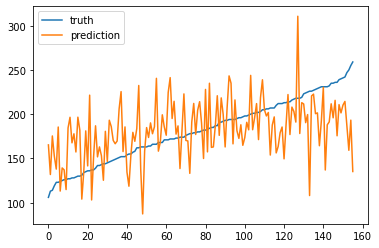

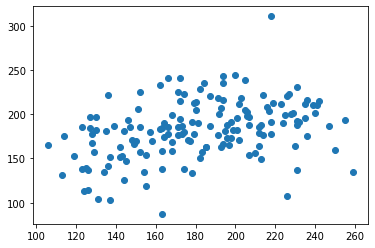

In [26]:
# Get predictions

import matplotlib.pyplot as plt

y = y_test
X = test_rest_ts_torch
Xc = test_rest_cheb_torch
N = len(y)

# pred = np.zeros(N)
# y1 = np.zeros(N) # rmse
# y2 = np.zeros(N) # mae

pred = []
y1 = []
y2 = []
y0 = []

for i in range(N):
    try:
        p = st_dag_att([[X[i], Xc[i]]]).cpu().detach()[0]
    except Exception as e:
        print('Got {:d} before failure'.format(i+1))
        break
#     p = fc_conv(X[i].unsqueeze(0).unsqueeze(0))[0,0].cpu().detach().numpy()
#     if p < 0 or p > 350:
#         continue
    y0.append(y[i,0])
    pred.append(p)
    y1.append((y[i,0]-p)**2)
    y2.append(abs(y[i,0]-p))
    
y0 = np.array(y0)
pred = np.array(pred)
y1 = np.array(y1)
y2 = np.array(y2)

# batch = []
# batchCheb = []
# for i in range(N):
#     batch.append(X[i].unsqueeze(0).unsqueeze(0))
#     batchCheb.append(Xc[i].unsqueeze(0))

# batch = torch.cat(batch)
# batchCheb = torch.cat(batchCheb)
# pred = st_graph_conv([batch, batchCheb]).view(N).cpu().detach().numpy()
# y1 = (y.reshape(N)-pred)**2 # rmse
# y2 = abs(y.reshape(N)-pred) # mae
    
print(np.corrcoef(y0.flatten(), pred))
print((y1.sum()/len(y1))**0.5/12)
print(y2.sum()/len(y2)/12)
# print(y1)
# print(y2)

idcs = np.argsort(y0,axis=0)
plt.plot(y0[idcs], label='truth')
plt.plot(pred[idcs], label='prediction')
plt.legend()
plt.show()

plt.scatter(y0.flatten(), pred)
plt.show()

In [27]:
# Check weights

print(st_dag_att.fc3.weight)

Parameter containing:
tensor([[-0.0642, -0.0493, -0.0689,  0.0452,  0.0251,  0.0303,  0.0203,  0.0256,
          0.0510,  0.0350,  0.0393,  0.0225,  0.0292,  0.0219, -0.0712, -0.0582,
         -0.0491, -0.0637,  0.0514,  0.0256,  0.0262, -0.0645, -0.0401,  0.0537,
          0.0517, -0.0512, -0.0601,  0.0401,  0.0485,  0.0426,  0.0162, -0.0270,
          0.0329,  0.0551, -0.0616, -0.0565,  0.0272, -0.0793,  0.0214, -0.0469,
          0.0373, -0.0425, -0.0651,  0.0529, -0.0510,  0.0552, -0.0736, -0.0454,
          0.0343,  0.0255, -0.0476,  0.0301,  0.0335,  0.0534,  0.0273,  0.0342,
          0.0471,  0.0212, -0.0539,  0.0563, -0.0383, -0.0750,  0.0543, -0.0541,
          0.0233,  0.0378, -0.0472,  0.0305,  0.0234,  0.0542, -0.0328,  0.0415,
         -0.0461, -0.0512, -0.0672, -0.0675, -0.0578,  0.0357, -0.0404,  0.0412,
          0.0237, -0.0657, -0.0373,  0.0309,  0.0461, -0.0594,  0.0558, -0.0578,
          0.0482, -0.0490,  0.0189, -0.0736, -0.0585,  0.0431, -0.0612, -0.0254,
      